<a href="https://colab.research.google.com/github/Taehee-K/Brain-Tumor-Classification/blob/main/code/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
path = os.path.dirname(os.path.abspath(__file__))
os.chdir(path)

# Split Data

* Train, Validation, Test 데이터 폴더 나누기

In [9]:
import shutil
 
original_dataset_dir = '../BrainTumorData'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = '../splitted'                           # train-validation 데이터 나누어 저장
os.mkdir(base_dir)
 
train_dir = os.path.join(base_dir, 'train')       # train data
os.mkdir(train_dir)
test_dir = os.path.join(base_dir, 'val')          # test data
os.mkdir(test_dir)

for cls in classes_list:     
    os.mkdir(os.path.join(train_dir, cls))
    os.mkdir(os.path.join(test_dir, cls))

* Train:Test 8:2 로 데이터 분할
* 각 클래스 별 데이터 수 확인

In [10]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.8)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[train_size:]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Brain Tumor ):  2010
Test size( Brain Tumor ):  503
Train size( Healthy ):  1669
Test size( Healthy ):  418


# Import Modules

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load Data
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader

# Pytorch --> MLP, CNN
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

In [13]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')
print(DEVICE)

cpu


In [14]:
BATCH_SIZE = 64
EPOCH = 30

In [15]:
n_classes = len(classes_list)
print(classes_list)           # 분류해야 할 클래스들
print(n_classes)      # 클래스 수 2개

['Brain Tumor', 'Healthy']
2


# Load Data

In [17]:
transform_base = transforms.Compose([transforms.Resize((227,227)),
                                     transforms.ToTensor(),
                                     transforms.Grayscale(num_output_channels=1)]) 
train_dataset = ImageFolder(root='../splitted/train', transform=transform_base)
test_dataset = ImageFolder(root='../splitted/val', transform=transform_base)

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

* 데이터 개수, 형태 확인

In [19]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(),'type:', X_train.type())
    print('y_train:', y_train.size(),'type:', y_train.type())
    break

X_train: torch.Size([64, 1, 227, 227]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


* 데이터 사진 확인하기

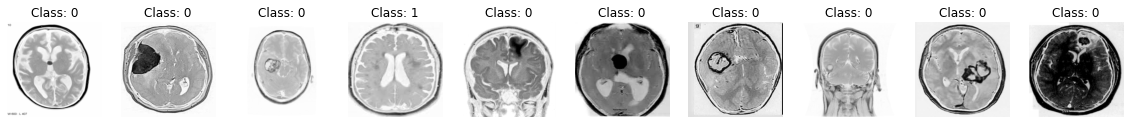

In [ ]:
pltsize = 2
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(227, 227), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# AlexNet 

* AlexNet Model

**ImageNet Classification with Deep Convolutional
Neural Networks** 에서의 **AlexNet** 구현

총 5개의 Convolutional Layer와 3개의 fully connected layer로 구성되어 있음

Input layer -> Conv1 -> MaxPool1 -> Norm1 -> Conv2 -> MaxPool2 -> Norm2 -> Conv3 -> Conv4 -> Conv5 -> MaxPool3 -> Dropout1 -> FC1 ->  Dropout2 -> FC2 -> Output layer

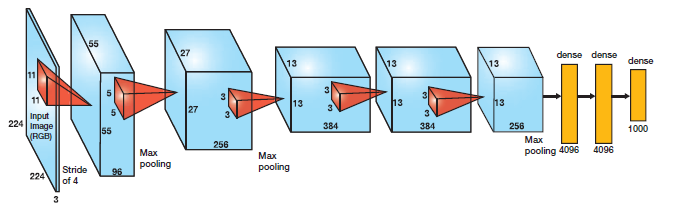

In [ ]:
class AlexNet(nn.Module): # AlexNet 모델 설계
    def __init__(self, n_classes = 2):   
        super(AlexNet, self).__init__()

        # 1st conv layer
        self.Conv_1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(96))
        
        # 2nd conv layer
        self.Conv_2 = nn.Sequential(
          nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(256))
        
        # 3rd conv layer
        self.Conv_3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # 4th conv layer
        self.Conv_4 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())
        
        # 5th conv layer
        self.Conv_5 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # 1st fully connected layer
        self.FC1 = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),
          nn.Linear(9216, 4096),
          nn.ReLU())

        # 2nd fully connected layer
        self.FC2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU())

        # 3rd fully connected layer --> output layer
        self.FC3 = nn.Sequential(
          nn.Linear(4096, n_classes))
    
    def forward(self, x):   # AlexNet forward propagation

        out = self.Conv_1(x)    
        out = self.Conv_2(out)
        out = self.Conv_3(out)
        out = self.Conv_4(out)
        out = self.Conv_5(out)
        out = self.FC1(out)
        out = self.FC2(out)
        out = self.FC3(out)

        return F.log_softmax(out) # softmax 통해 최종 output 계산

# print model summary
alexnet = AlexNet().to(DEVICE)
summary(alexnet, (1, 227, 227)) # summary code 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
       BatchNorm2d-4           [-1, 96, 27, 27]             192
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
         MaxPool2d-7          [-1, 256, 13, 13]               0
       BatchNorm2d-8          [-1, 256, 13, 13]             512
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

* Train Model

In [ ]:
def train(model, train_loader, optimizer):
    model.train()                         # AlexNet 모델 train 상태로
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)  # data, target 값 DEVICE에 할당
        optimizer.zero_grad()                              # optimizer gradient 값 초기화
        output = model(data)                               # 할당된 데이터로 output 계산
        loss =  criterion(output, target)                  # Cross Entropy Loss 사용해 loss 계산
        loss.backward()                                    # 계산된 loss back propagation
        optimizer.step()                                   # parameter update

* Evaluate Model

In [ ]:
def evaluate(model, test_loader):
    model.eval()      # 모델 평가 상태로
    test_loss = 0     # test_loss 초기화
    correct = 0       # 맞게 예측한 0 값으로 초기화
    
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)     # data, target DEVICE에 할당
            output = model(data)                                  # output 계산
            test_loss += criterion(output, target).item()         # loss 계산(총 loss 에 더해주기)
            pred = output.max(1, keepdim=True)[1]                 # 계산된 벡터값 중 가장 큰 값 가지는 class 예측
            correct += pred.eq(target.view_as(pred)).sum().item() # 맞게 예측한 값 세기
   
    test_loss /= len(test_loader.dataset)                         # 평균 loss
    test_accuracy = 100. * correct / len(test_loader.dataset)     # test(validation) 데이터 정확도
    return test_loss, test_accuracy 

## Train AlexNet

In [ ]:
import time
import copy
 
def train_model(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  # beset accuracy 초기화
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()                                     # 학습 시간 계산
        train(model, train_loader, optimizer)                   # train 데이터로 학습
        train_loss, train_acc = evaluate(model, train_loader)   # train_loss, train_acc 계산
        val_loss, val_acc = evaluate(model, val_loader)         # valid_loss, valid_acc 계산
        
        if val_acc>best_acc:  # update best accuracy
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since # 학습 시간 출력
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

    model.load_state_dict(best_model_wts)  
    return model

model = train_model(alexnet ,train_loader, test_loader, optimizer)  	# 모델 학습시키기
torch.save(model,'AlexNet.pt') 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


-------------- epoch 1 ----------------
train Loss: 0.0076, Accuracy: 77.85%
val Loss: 0.0093, Accuracy: 74.81%
Completed in 0m 36s
-------------- epoch 2 ----------------
train Loss: 0.0080, Accuracy: 73.80%
val Loss: 0.0086, Accuracy: 74.38%
Completed in 0m 36s
-------------- epoch 3 ----------------
train Loss: 0.0063, Accuracy: 82.09%
val Loss: 0.0094, Accuracy: 67.97%
Completed in 0m 36s
-------------- epoch 4 ----------------
train Loss: 0.0064, Accuracy: 81.27%
val Loss: 0.0156, Accuracy: 76.22%
Completed in 0m 36s
-------------- epoch 5 ----------------
train Loss: 0.0132, Accuracy: 68.66%
val Loss: 0.0201, Accuracy: 71.12%
Completed in 0m 36s
-------------- epoch 6 ----------------
train Loss: 0.0056, Accuracy: 85.65%
val Loss: 0.0185, Accuracy: 72.96%
Completed in 0m 36s
-------------- epoch 7 ----------------
train Loss: 0.0042, Accuracy: 88.20%
val Loss: 0.0129, Accuracy: 66.45%
Completed in 0m 35s
-------------- epoch 8 ----------------
train Loss: 0.0024, Accuracy: 94.29%

## Test AlexNet

In [ ]:
model=torch.load('AlexNet.pt')
model.eval()
loss, acc = evaluate(model, test_loader)

print('Test Accuracy: {:.4f}'.format(acc))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 94.0282


In [ ]:
from sklearn.metrics import classification_report

def prediction(model, data_loader):
    model.eval()
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    
    with torch.no_grad():
      for i, (data, label) in enumerate(test_loader):
        data = data.to(DEVICE)        # 데이터 DEVICE에 할당
        label = label.to(DEVICE)      # 라벨 값 DEVICE에 할당
        outputs = model(data)         # 예측
        _, preds = torch.max(outputs, 1)  # 가장 높은 확률 가지는 class 예측

        # Batch 단위 예측값 append 하기
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        
    # Classification Report
    print(classification_report(lbllist.numpy(), predlist.numpy())) # 클래스별 accuracy, recall, f1-score 
    return 

In [ ]:
prediction(model, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


              precision    recall  f1-score   support

           0       0.96      0.93      0.94       503
           1       0.92      0.95      0.94       418

    accuracy                           0.94       921
   macro avg       0.94      0.94      0.94       921
weighted avg       0.94      0.94      0.94       921

